In [ ]:
%%sql


# Trabalho de Processamento de Linguagem Natural — **Objetivo A
Participantes: *INGRIT DOS ANJOS GOMES BRAZ, RICARDO RODRIGUES BARCELAR*

**Tarefa:** Dado **apenas o título** do trabalho, estimar se o artigo foi publicado **antes de 2023** (`ano < 2023`) ou **depois de 2023** (`ano > 2023`).  
Entradas com `ano == 2023` são removidas para manter a formulação estrita (*antes* vs *depois* de 2023).

**Dataset:** `eventos_artigos_filtrados.csv` (SILVA et al., 2025). Colunas esperadas: `titulo`, `resumo`, `evento`, `ano`.

> **Dica:** Se o CSV completo ainda não estiver disponível, este notebook busca um arquivo de exemplo chamado **`Exemplo.csv`** (anexo) para você conseguir rodar fim‑a‑fim.

## 1. Ambiente e importações

In [3]:
# Reprodutibilidade
SEED = 42

import os
import unicodedata
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, roc_auc_score, RocCurveDisplay)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(SEED)
plt.rcParams['figure.dpi'] = 120

## 2. Carregamento dos dados

O notebook tenta localizar o arquivo:
1. `./eventos_artigos_filtrados.csv`


In [17]:
from pathlib import Path
import unicodedata
import pandas as pd
from typing import Iterable, Optional, Set

def _normalize_col(name: str) -> str:
    """Normaliza nome de coluna: minúsculas, remove acentos e troca espaços por underscore."""
    name = name.strip().lower()
    name = "".join(ch for ch in unicodedata.normalize("NFKD", name) if not unicodedata.combining(ch))
    name = name.replace(" ", "_")
    return name

def carregar_dados(
    caminho: str = "eventos_artigos_filtrados.csv",
    encoding: str = "utf-8",
    normalizar_colunas: bool = True,
    colunas_obrigatorias: Optional[Iterable[str]] = ("titulo", "ano"),
    n_preview: int = 3,
) -> pd.DataFrame:
    """
    Lê o CSV de artigos (UTF-8), normaliza nomes de colunas e valida colunas mínimas.

    Parâmetros
    ----------
    caminho : str
        Caminho para o CSV (default: 'eventos_artigos_filtrados.csv').
    encoding : str
        Encoding do arquivo (default: 'utf-8').
    normalizar_colunas : bool
        Se True, normaliza nomes de colunas (minúsculas, sem acentos, '_' nos espaços).
    colunas_obrigatorias : Iterable[str] | None
        Conjunto de colunas que precisam existir. Use None para pular a checagem.
    n_preview : int
        Número de linhas para exibir no preview (se > 0).

    Retorno
    -------
    pd.DataFrame
        DataFrame carregado e (opcionalmente) com colunas normalizadas.
    """
    csv_path = Path(caminho)
    if not csv_path.exists():
        raise FileNotFoundError(
            f"CSV não encontrado em '{csv_path.resolve()}'. "
            f"Coloque '{caminho}' ao lado do notebook ou ajuste o caminho."
        )

    print(f"Usando arquivo: {csv_path}")
    df = pd.read_csv(csv_path, encoding=encoding)
    print(f"Leitura OK | shape: {df.shape}")

    if normalizar_colunas:
        df.columns = [_normalize_col(c) for c in df.columns]

    print("Colunas:", list(df.columns))

    if colunas_obrigatorias is not None:
        required: Set[str] = set(colunas_obrigatorias)
        missing = required - set(df.columns)
        if missing:
            raise ValueError(f"Faltam colunas obrigatórias: {missing}")

    if n_preview and n_preview > 0:
        display(df.head(n_preview))

    return df


## 3. Preparação do alvo e limpeza

- Converte `ano` para numérico e remove linhas inválidas.
- Remove `ano == 2023`.
- Cria `y` binário: `0` se `ano < 2023` e `1` se `ano > 2023`.
- Usa **apenas `titulo`** como entrada textual.

In [19]:
df = df.copy()
df['ano_edicao'] = pd.to_numeric(df['ano_edicao'], errors='coerce')
df = df.dropna(subset=['ano_edicao'])

# Remove ano == 2023
n_2023 = int((df['ano_edicao'] == 2023).sum())
df = df.loc[df['ano_edicao'] != 2023].reset_index(drop=True)

# Label
df['y'] = (df['ano_edicao'] > 2023).astype(int)

# Texto
df = df.dropna(subset=['titulo_artigo'])
df['titulo_artigo'] = df['titulo_artigo'].astype(str).str.strip()

print({
    'removidos_ano_2023': n_2023,
    'total_restante': len(df),
    'positivos_(ano>2023)': int(df['y'].sum()),
    'negativos_(ano<2023)': int((1 - df['y']).sum())
})

display(df[['titulo_artigo','ano_edicao','y']].head(5))

{'removidos_ano_2023': 1368, 'total_restante': 11261, 'positivos_(ano>2023)': 2108, 'negativos_(ano<2023)': 9153}


,titulo_artigo,ano_edicao,y
0,Auditoria de Sistemas Eleitorais: o Caso São D...,2001,0
1,Acessibilidade para Adultos de Meia-Idade e Id...,2010,0
2,Personas na interação com serviços de e-gov vi...,2010,0
3,Uma Engenharia de Domínio Baseada em Padrões d...,2010,0
4,A Inteligência Coletiva na Web: Uma Análise de...,2010,0


## 4. Divisão treino/teste (estratificada)
Treino (75%) → usado para aprender o modelo.
Teste (25%) → nunca visto pelo modelo, usado para avaliar desempenho real.
Com stratify=y, a divisão respeita o balanceamento de classes.

In [20]:
X = df['titulo_artigo'].values
y = df['y'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=y
)

print(f'Treino: {len(X_train)} | Teste: {len(X_test)}')

Treino: 8445 | Teste: 2816


## 5. Vetorização TF‑IDF (título)

- `strip_accents='unicode'`
- `ngram_range=(1,2)` (uni + bi)
- `min_df=2` (reduz ruído)

In [21]:
tfidf = TfidfVectorizer(
    strip_accents='unicode',
    ngram_range=(1,2),
    min_df=2
)

## 6. Baseline — Regressão Logística

In [22]:
pipe_lr = Pipeline([
    ('tfidf', tfidf),
    ('clf', LogisticRegression(
        random_state=SEED,
        max_iter=2000,
        class_weight='balanced'
    ))
])

pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)

# Probabilidades para ROC-AUC
try:
    proba_lr = pipe_lr.predict_proba(X_test)[:,1]
    auc_lr = roc_auc_score(y_test, proba_lr)
except Exception:
    proba_lr = None
    auc_lr = np.nan

acc_lr = accuracy_score(y_test, pred_lr)
f1_lr  = f1_score(y_test, pred_lr, average='binary')

print({'accuracy': acc_lr, 'f1': f1_lr, 'roc_auc': auc_lr})
print('\nClassification Report (LogReg)\n', classification_report(y_test, pred_lr, digits=4))

{'accuracy': 0.7560369318181818, 'f1': 0.45258964143426295, 'roc_auc': 0.7552401842654789}

Classification Report (LogReg)
               precision    recall  f1-score   support

           0     0.8836    0.8060    0.8430      2289
           1     0.3901    0.5389    0.4526       527

    accuracy                         0.7560      2816
   macro avg     0.6369    0.6725    0.6478      2816
weighted avg     0.7913    0.7560    0.7700      2816



## 7. LinearSVC + calibração (com busca de hiperparâmetros)

- `LinearSVC` costuma performar bem em texto.
- Calibramos com `sigmoid` para obter probabilidades (ROC‑AUC).
- Busca de `C` via `GridSearchCV` (otimizando F1).

In [23]:
pipe_svc = Pipeline([
    ('tfidf', tfidf),
    ('clf', LinearSVC(random_state=SEED))
])

param_grid = {'clf__C': [0.5, 1.0, 2.0, 4.0]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    scoring='f1'
)
gs.fit(X_train, y_train)
print('Melhor C:', gs.best_params_, '| Melhor F1 (CV):', round(gs.best_score_, 4))

best_svc = Pipeline([
    ('tfidf', tfidf),
    ('clf', LinearSVC(C=gs.best_params_['clf__C'], random_state=SEED))
])

calibrated = CalibratedClassifierCV(best_svc, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)

pred_svc = calibrated.predict(X_test)
proba_svc = calibrated.predict_proba(X_test)[:,1]

acc_svc = accuracy_score(y_test, pred_svc)
f1_svc  = f1_score(y_test, pred_svc, average='binary')
auc_svc = roc_auc_score(y_test, proba_svc)

print({'accuracy': acc_svc, 'f1': f1_svc, 'roc_auc': auc_svc})
print('\nClassification Report (LinearSVC)\n', classification_report(y_test, pred_svc, digits=4))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

Melhor C: {'clf__C': 4.0} | Melhor F1 (CV): 0.4011
{'accuracy': 0.8203125, 'f1': 0.11846689895470383, 'roc_auc': 0.7224175849682873}

Classification Report (LinearSVC)
               precision    recall  f1-score   support

           0     0.8220    0.9943    0.9000      2289
           1     0.7234    0.0645    0.1185       527

    accuracy                         0.8203      2816
   macro avg     0.7727    0.5294    0.5092      2816
weighted avg     0.8035    0.8203    0.7537      2816



## 8. Matrizes de confusão e curva ROC

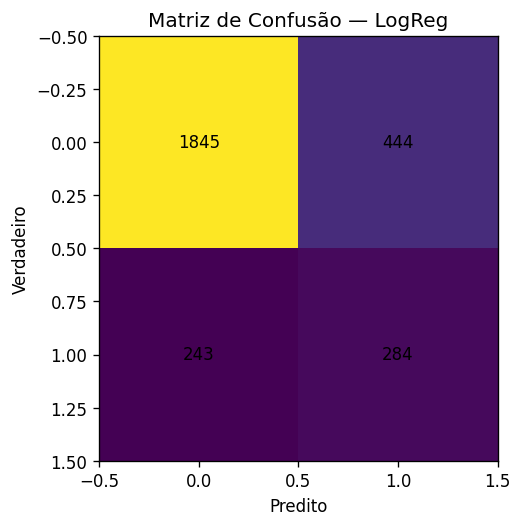

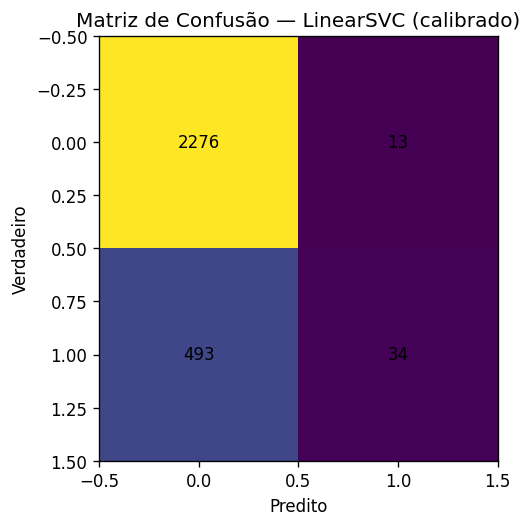

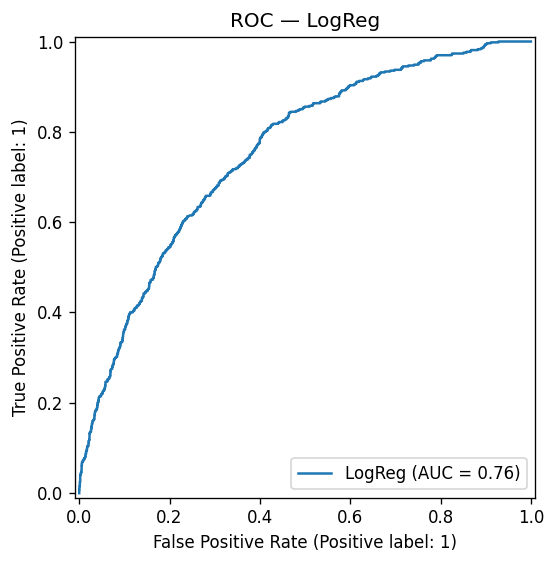

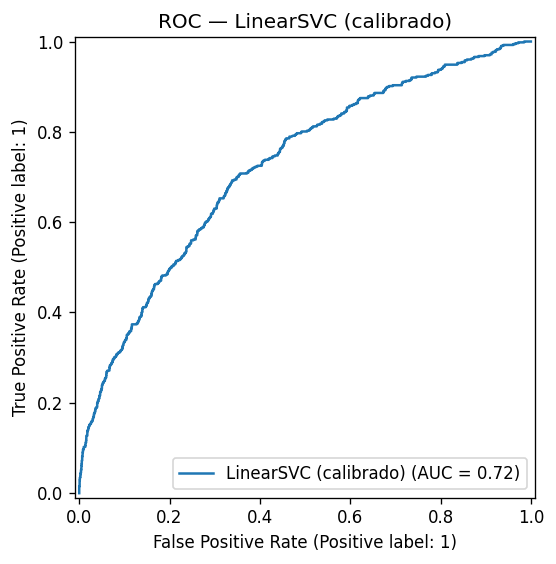

In [24]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4.5,4.5))
    im = ax.imshow(cm, aspect='auto')
    ax.set_title(title)
    ax.set_xlabel('Predito')
    ax.set_ylabel('Verdadeiro')
    for (i,j), val in np.ndenumerate(cm):
        ax.text(j, i, int(val), ha='center', va='center')
    plt.tight_layout()
    plt.show()

plot_cm(y_test, pred_lr, 'Matriz de Confusão — LogReg')
plot_cm(y_test, pred_svc, 'Matriz de Confusão — LinearSVC (calibrado)')

# Curva ROC (quando houver probabilidades)
if isinstance(proba_lr, np.ndarray):
    RocCurveDisplay.from_predictions(y_test, proba_lr, name='LogReg')
    plt.title('ROC — LogReg')
    plt.tight_layout()
    plt.show()

RocCurveDisplay.from_predictions(y_test, proba_svc, name='LinearSVC (calibrado)')
plt.title('ROC — LinearSVC (calibrado)')
plt.tight_layout()
plt.show()

## 9. Salvando predições do conjunto de teste

## 11. Seção para o relatório (até 2 páginas)

> Copie/edite este texto para compor seu relatório final (PDF até 2 páginas).

**Objetivo.** Estimar, a partir do **título** do artigo, se sua publicação ocorreu **antes de 2023** (`ano < 2023`) ou **depois de 2023** (`ano > 2023`). Entradas com `ano == 2023` foram excluídas.

**Dados.** Conjunto `eventos_artigos_filtrados.csv` (SILVA et al., 2025), com colunas `titulo`, `resumo`, `evento`, `ano`. Utilizamos apenas `titulo`.

**Pré-processamento.** Conversão do campo `ano` para numérico; remoção de entradas inválidas; exclusão de `ano == 2023`; normalização mínima do texto (remover espaços excedentes).

**Representação textual.** `TF‑IDF` sobre `titulo` com `strip_accents='unicode'`, `ngram_range=(1,2)` e `min_df=2` — combinação simples e eficaz para títulos curtos.

**Modelos.**
- **Baseline:** Regressão Logística (`class_weight='balanced'`), visando robustez a desbalanceamentos.
- **Modelo principal:** `LinearSVC` com calibração sigmoidal (`CalibratedClassifierCV`) para obter probabilidades; hiperparâmetro `C` selecionado por `GridSearchCV` com `StratifiedKFold` (5 folds) e métrica `F1`.

**Protocolo de avaliação.** Divisão estratificada treino/teste (75/25). Métricas reportadas em teste: `accuracy`, `F1` (classe positiva `ano>2023`) e `ROC‑AUC`. Também são apresentadas matrizes de confusão e curva ROC.

**Resultados.** Consulte a saída das seções 6 e 7. Em geral, `LinearSVC` tende a superar a baseline em F1 e AUC, mas a conclusão depende da distribuição real dos dados deste trabalho.

**Limitações e oportunidades.** Os títulos são curtos e com pouco contexto semântico; incluir bigramas ajuda, mas pode haver ambiguidade temporal (palavras de moda aparecem antes e depois de 2023). Alternativas incluem: enriquecimento com `evento`/`resumo`; features de tempo (por exemplo, vocabulário emergente); modelos pré‑treinados leves (e.g., BERTimbau) com *fine-tuning*; ou meta‑features (comprimento do título, presença de anos no título etc.).

**Reprodutibilidade.** Código em Python (scikit‑learn), semente aleatória fixa (`SEED=42`). Predições do teste foram salvas em `/mnt/data/predicoes_teste_A.csv`.

In [26]:
out = pd.DataFrame({
    'titulo': X_test,
    'y_true': y_test,
    'y_pred_logreg': pred_lr,
    'y_pred_svc': pred_svc,
    'proba_svc': proba_svc
})
out_path = Path("resultados/predicoes_teste_A.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)  # cria a pasta se não existir
out.to_csv(out_path, index=False, encoding="utf-8")
print(f"Arquivo salvo em: {out_path.resolve()}")
display(out.head(10))

Arquivo salvo em: /Users/ingritdosanjosgomes/PycharmProjects/Trabalho_PLN/resultados/predicoes_teste_A.csv


,titulo,y_true,y_pred_logreg,y_pred_svc,proba_svc
0,Um Mapeamento das Práticas Educativas utilizan...,1,0,0,0.096135
1,Um Modelo para Predição Individualizada da Det...,0,0,0,0.077261
2,Tuning of FP-PID Controller based on PSO Algor...,0,0,0,0.070231
3,Abordagens Orientadas a Modelos no desenvolvim...,0,0,0,0.111228
4,Supervised models for detecting GPS attacks an...,1,1,0,0.365664
5,On the Use of Visual Perception for Unmanned S...,1,0,0,0.105596
6,Modelo para Representação do Conhecimento em P...,0,0,0,0.138795
7,On the Understanding of How to Measure the Ben...,0,1,0,0.270475
8,Metodologias Ativas à Luz de Comenius: uma Exp...,0,0,0,0.079040
9,Avaliação das Técnicas de Detecção do Ataque S...,0,0,0,0.143579
